In [2]:
from sklearn.model_selection import KFold
import keras.preprocessing.text
import os
import numpy as np
from IPython.display import HTML
import random
from HMM import unsupervised_HMM
import nltk
import matplotlib.pyplot as plt

## Tokenize

In [3]:
file = open('data/dataset.txt', 'r')
s = file.read()
txt_list = keras.preprocessing.text.text_to_word_sequence(s,
                                               filters='0123456789!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n',
                                               lower=True,
                                               split=' ')
# print(txt_list)
Tokenizer = keras.preprocessing.text.Tokenizer(num_words=None,
                                   filters='0123456789!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,
                                   split=" ",
                                   char_level=False,
                                   oov_token=None)
Tokenizer.fit_on_texts(txt_list)
sequences = Tokenizer.texts_to_sequences(txt_list)
word_docs = Tokenizer.word_docs
word_index = Tokenizer.word_index
word_counts = Tokenizer.word_counts
# print(word_counts)
# occ = 0
# for val in word_counts.values():
#     if val == 1:
#         occ += 1
# print(occ)
# print(len(word_counts))

## Load Dictionary

In [7]:
import json
syllable_dict = json.load(open('data/my_syllable_dict.json'))
word_to_syllable_dict = json.load(open('data/word_to_syllable_dict.json'))
rhyme_dict = json.load(open('data/my_rhyme_dict.json'))
reverse_dict = dict(zip(word_index.values(), word_index.keys()))
word_to_rhyme_dict = json.load(open('data/word_to_rhyme_dict.json'))
# print(rhyme_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'data/my_syllable_dict.json'

## Generate Sequence

In [4]:
def generate_sequence(file_name, seq_type, Tokenizer):
    '''
    returns X: a list of list, tokenized
    '''
    if seq_type == 'poem':
        file = open(file_name, 'r')
        s = file.read()
        s_list = keras.preprocessing.text.text_to_word_sequence(s,
                                                       filters='!"#$%&()+,./:;<=>?@[\\]^_`{|}~\t\n',
                                                       lower=True,
                                                       split=' ')
        poem_list = []
        for s in s_list:
            if s == '1':
                poem = []
            elif s.isdigit() or '*' in s:
                poem_list.append(poem)
                poem = []
            else:
                poem.append(s)
        poem_list.append(poem)
        # print(poem_list)
        token_list = []
        for poem in poem_list:
            real_list = []
            temp_list = Tokenizer.texts_to_sequences(poem)
            for num in temp_list:
                real_list.append(num[0] - 1)
            token_list.append(real_list)
        return token_list
    
    if seq_type == 'line':
        file = open('data/dataset.txt', 'r')
        s = file.read()
        we_list = s.split('\n')
        line_list = []
        for w in we_list:
            temp = keras.preprocessing.text.text_to_word_sequence(w,
                                                       filters='*!"#$%&()+,./:;<=>?@[\\]^_`{|}~\t\n',
                                                       lower=True,
                                                       split=' ')
            if len(temp) > 1:
                line_list.append(temp)
        # print(line_list)

        token_list = []
        for line in line_list:
            real_list = []
            temp_list = Tokenizer.texts_to_sequences(line)
            for num in temp_list:
                real_list.append(num[0] - 1)
            token_list.append(real_list)
        # print(token_list)
        return token_list

In [5]:
X = generate_sequence('data/dataset.txt', 'line', Tokenizer)
temp=[]
for Xi in X:
    Xi=list(reversed(Xi))
    temp.append(Xi)
X=temp

In [6]:
X0 = generate_sequence('data/dataset.txt', 'line', Tokenizer)


## Train

In [22]:
def cross_validation(X, fold, state, iteration, lamda_A, lamda_O):
    print('hidden state: %d' % state)
    random.shuffle(X)
    # get average length
    sum = 0
    max_ob = 0
    for x in X:
        sum += len(x)
        if max(x) > max_ob:
            max_ob = max(x)
    avg = int(sum / len(X))
    
    # fold split and train
    kf = KFold(n_splits=fold)
    count = 1
    max_prob = 0
    sum_prob = 0
    sum_count = 0
    for train_index, test_index in kf.split(X):
        if count%2 == 0:
            count+=1
            continue
            
#         if count != 1:
#             break
#         count += 1
        print('fold %d' % count)
        count += 1
        # print(X[train_index[0]:(train_index[-1]-1)])
        X_train = []
        for i in train_index:
            X_train.append(X[i])
        # print(X_train)
        hmm = unsupervised_HMM(X_train, state, iteration, max_ob+1, lamda_A, lamda_O)
        # print(hmm.A)
        # print(hmm.O)
        
        # print generated sequence
#         emission, states = hmm.generate_emission(avg)
#         emission = reverse_check(word_index, emission)
#         text = ''
#         for e in emission:
#             text = str(text + e + ' ')
#         print('Sample Text:')
#         print(text)
        
        # calculate validation probability
        prob = 0
        for i in test_index:
            prob += hmm.probability_alphas(X[i])
        prob = prob / len(test_index)
        if prob > max_prob:
            max_prob = prob
        sum_prob += prob
        sum_count += 1
    print('Max Probability in Fold: %s' % max_prob)
    print('Avg Probability in Fold: %s' % (sum_prob / sum_count))

In [8]:
def reverse_check(word_index, emission):
    reverse_dict = dict(zip(word_index.values(), word_index.keys()))
    res = []
    for e in emission:
        res.append(reverse_dict[e+1])
    return res

In [9]:
def train_hmm(X, state, iteration, lamda_A, lamda_O):
    random.shuffle(X)
    # get average length
    sum = 0
    max_ob = 0
    for x in X:
        sum += len(x)
        if max(x) > max_ob:
            max_ob = max(x)
    avg = int(sum / len(X))
    hmm = unsupervised_HMM(X, state, iteration, max_ob+1, lamda_A, lamda_O)
    return hmm

In [30]:
num_state = [2, 4, 6, 8, 10]
for state in num_state:
    cross_validation(X, 10, state, 50, 10000, 10000)

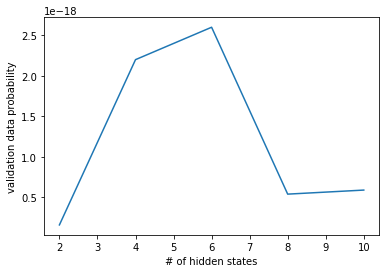

In [29]:
import matplotlib.pyplot as plt

nstat=np.array([2,4,6,8,10])
cv=np.array([0.16,2.2,2.6,0.54,0.59])*1e-18
plt.figure()
plt.plot(nstat,cv)
plt.xlabel('# of hidden states')
plt.ylabel('validation data probability')
plt.savefig('CV.png')
plt.show()



In [10]:
hmm = train_hmm(X, 6, 50, 10000, 10000)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50


## Generate Poem

In [65]:
# def generate_line(hmm):
#     states = []
#     emission = []
#     words = []
    
#     # choose starting state
#     y0 = np.random.randint(hmm.L)
#     states.append(y0)
#     x0 = np.random.choice(hmm.D, p=hmm.O[y0])
#     x_word = reverse_dict[x0+1]
#     while x_word not in word_to_syllable_dict:
#         x0 = np.random.choice(hmm.D, p=hmm.O[y0])
#         x_word = reverse_dict[x0+1]
#     emission.append(x0)
#     words.append(x_word)
    
#     # generate middle word
#     index = 1
#     remain_syllable = 10 - int(word_to_syllable_dict[x_word][-1])
#     while remain_syllable > 3:
#         y_temp = np.random.choice(hmm.L, p=hmm.A[states[index-1]])
#         states.append(y_temp)
#         x_temp = np.random.choice(hmm.D, p=hmm.O[states[index-1]])
#         x_word = reverse_dict[x_temp+1]
#         while x_word not in word_to_syllable_dict:
#             x_temp = np.random.choice(hmm.D, p=hmm.O[y0])
#             x_word = reverse_dict[x_temp+1]
#         emission.append(x_temp)
#         words.append(x_word)
#         remain_syllable -= int(word_to_syllable_dict[x_word][-1])
#         index += 1
        
#     # generate last word pool
#     word_pool = []
#     E_syllable = 'E' + str(remain_syllable)
#     # print(E_syllable)
#     if E_syllable in syllable_dict:
#         word_pool = word_pool + syllable_dict[E_syllable]
#     word_pool = word_pool + syllable_dict[str(remain_syllable)]
#     real_word_pool = []
#     for word in word_pool:
#         rhyme = rhyme_dict[word]
#         if 
#     # print(word_pool)
    
#     y_temp = np.random.choice(hmm.L, p=hmm.A[states[index-1]])
#     states.append(y_temp)
#     x_temp = np.random.choice(hmm.D, p=hmm.O[states[index-1]])
#     x_word = reverse_dict[x_temp+1]
#     while x_word not in word_pool:
#         x_temp = np.random.choice(hmm.D, p=hmm.O[states[index-1]])
#         x_word = reverse_dict[x_temp+1]
#     emission.append(x_temp)
#     words.append(x_word)
    
#     return emission, words

In [20]:
# emission, words = generate_line(hmm)
# print(emission)
# print(words)

# Visualization

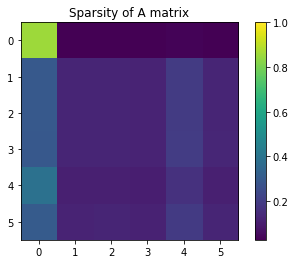

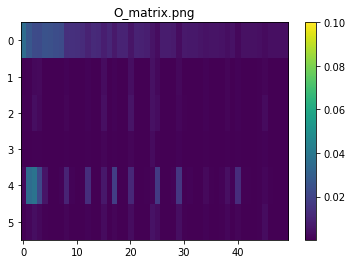

In [12]:
# Visualize A and O
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

visualize_sparsities(hmm, O_max_cols=50)

In [14]:
# Get obs_map
obs_map={}
for lx in X:
    for ob in lx:
        for ele in word_index:
            if word_index[ele]==ob:
                obs_map[ele]=ob
                break


In [17]:
def p_observations(lines):
    # Convert text to dataset.
#     lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text2wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        # plt.savefig('wordcloud.png')
        plt.show()
        plt.savefig(title)

    return wordcloud

def states2wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 10000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)
    print(len(emission))
    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    print(min(obs_lst))
    for i in range(n_states):
        obs_lst = obs_count[i]
#         print(i,obs_map_r)

        # sentence = [obs_map_r[j] for j in obs_lst]
#         obs_lst = [x-1 for x in obs_lst]
        sentence=[]
        for jj in obs_lst:
#             print(jj)
            sentence.append(obs_map_r[jj+1])
            
        sentence_str = ' '.join(sentence)

        wordclouds.append(text2wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))
#         plt.savefig('State%d.png' % i)

    return wordclouds

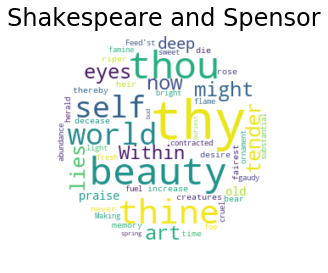

10000
0


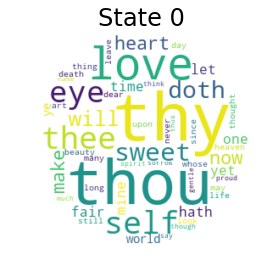

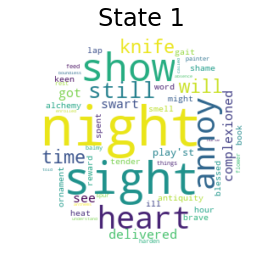

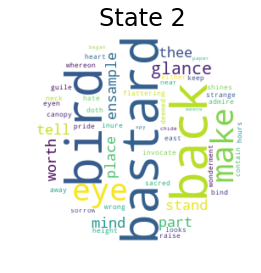

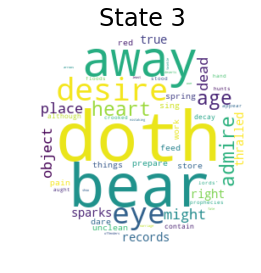

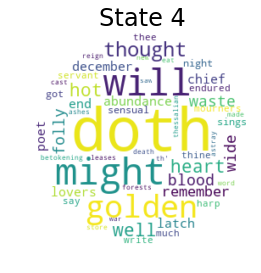

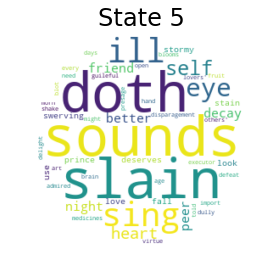

In [18]:
# Get wordclouds
import re
from wordcloud import WordCloud



text = open(os.path.join(os.getcwd(), 'data/dataset2.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare and Spensor')
obs = X
# obs_map = word_index
# obs, obs_map = parse_observations(text)

wordclouds = states2wordclouds(hmm, obs_map)

In [15]:
anim = animate_emission(hmm, obs_map, M=8)
HTML(anim.to_html5_video())

6

Animating...
